In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import torch
import time
import visdom

import pyro
import pyro.optim as optim
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO

from bayesian_air import BayesianSequenceModel
from utils.visualize import *

import pyro.contrib.examples.multi_mnist as multi_mnist
from pyro.contrib.examples.util import get_data_directory
# from viz import draw_many, tensor_to_objs

In [3]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

In [7]:
def load_data():
    inpath = get_data_directory(".")
    X_np, Y = multi_mnist.load(inpath)
    X_np = X_np.astype(np.float32)
    X_np /= 255.0
    X = torch.from_numpy(X_np)
    # Using FloatTensor to allow comparison with values sampled from
    # Bernoulli.
    counts = torch.FloatTensor([len(objs) for objs in Y])
    return X, counts

In [8]:
X, true_counts = load_data()

downloading data


Extracting /home/abhi/Dynamics-Model-Search/dynamics/src/.data/MNIST/raw/train-images-idx3-ubyte.gz to /home/abhi/Dynamics-Model-Search/dynamics/src/.data/MNIST/raw


Extracting /home/abhi/Dynamics-Model-Search/dynamics/src/.data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/abhi/Dynamics-Model-Search/dynamics/src/.data/MNIST/raw


Extracting /home/abhi/Dynamics-Model-Search/dynamics/src/.data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/abhi/Dynamics-Model-Search/dynamics/src/.data/MNIST/raw


Extracting /home/abhi/Dynamics-Model-Search/dynamics/src/.data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/abhi/Dynamics-Model-Search/dynamics/src/.data/MNIST/raw
Processing...
Done!
download complete.
Generating multi-MNIST dataset...




Done!


In [10]:
X.shape, true_counts.shape

(torch.Size([60000, 50, 50]), torch.Size([60000]))

In [88]:
vrnn = BayesianSequenceModel(num_steps=100, device=device)

In [89]:
adam = optim.Adam({"lr": 1.0e-3})
elbo = Trace_ELBO()
svi = SVI(vrnn.model, vrnn.guide, adam, loss=elbo)

In [ ]:
# Do inference.
t0 = time.time()
examples_to_viz = X[5:10]
epochs = 100
batch_size = 64
N = X.shape[0]
examples_to_viz = X[5:10]


for i in range(1, epochs + 1):

    loss = svi.step(X, batch_size=batch_size)

    if i % 1 == 0:
        print('i={}, epochs={:.2f}, elapsed={:.2f}, elbo={:.2f}'.format(
            i,
            (i * batch_size) / N,
            (time.time() - t0) / 3600,
            loss / N))

    if i % 10 == 0:
        trace = poutine.trace(air.guide).get_trace(examples_to_viz)
        z, recons = poutine.replay(air.prior, trace=trace)(examples_to_viz.shape[0])
        z_wheres = tensor_to_objs(latents_to_tensor(z))

        # Show data with inferred objection positions.
        # vis.images(draw_many(examples_to_viz, z_wheres))
        # Show reconstructions of data.
        # vis.images(draw_many(recons, z_wheres))

    '''
    if args.eval_every > 0 and i % args.eval_every == 0:
        # Measure accuracy on subset of training data.
        acc, counts, error_z, error_ix = count_accuracy(X, true_counts, air, 1000)
        print('i={}, accuracy={}, counts={}'.format(i, acc, counts.numpy().tolist()))
        if args.viz and error_ix.size(0) > 0:
            vis.images(draw_many(X[error_ix[0:5]], tensor_to_objs(error_z[0:5])),
                       opts=dict(caption='errors ({})'.format(i)))

    if 'save' in args and i % args.save_every == 0:
        print('Saving parameters...')
        torch.save(air.state_dict(), args.save)
    '''

In [ ]:
# Do inference.
t0 = time.time()
epochs = 1000
batch_size = 256
N = X_train.shape[0]

pyro.poutine.util.enable_validation(True)

X_example = torch.from_numpy(X_train[0:5]).to(device)
A_example = torch.from_numpy(A_train[0:5]).to(device)
Y_example = torch.from_numpy(Y_train[0:5]).to(device)

for i in range(1, epochs+1):

    loss = svi.step(X=torch.from_numpy(X_train[:512]).to(device), 
                    A=torch.from_numpy(A_train[:512]).to(device), 
                    Y=torch.from_numpy(Y_train[:512]).to(device), 
                    batch_size=batch_size)

    if i % 1 == 0:
        print('i={}, epochs={:.2f}, elapsed={:.2f}, elbo={:.2f}'.format(
            i,
            (i * batch_size) / N,
            (time.time() - t0) / 3600,
            loss / N))

    if i % 10 == 0:
        trace = poutine.trace(vrnn.guide).get_trace(X=X_example, A=A_example, Y=Y_example, batch_size=X_example.shape[0])
        Y_hat_example, Z_example = poutine.replay(vrnn.prior, trace=trace)(X_example.shape[0])
        print(Y_hat_example.shape)

        # Show data with inferred objection positions.
        # vis.images(draw_many(examples_to_viz, z_wheres))
        # Show reconstructions of data.
        # vis.images(draw_many(recons, z_wheres))
    '''
    if args.eval_every > 0 and i % args.eval_every == 0:
        # Measure accuracy on subset of training data.
        acc, counts, error_z, error_ix = count_accuracy(X, true_counts, air, 1000)
        print('i={}, accuracy={}, counts={}'.format(i, acc, counts.numpy().tolist()))
        if args.viz and error_ix.size(0) > 0:
            vis.images(draw_many(X[error_ix[0:5]], tensor_to_objs(error_z[0:5])),
                       opts=dict(caption='errors ({})'.format(i)))
    
    if 'save' in args and i % args.save_every == 0:
        print('Saving parameters...')
        torch.save(air.state_dict(), args.save)
    '''

i=1, epochs=0.00, elapsed=0.00, elbo=nan
i=2, epochs=0.00, elapsed=0.00, elbo=nan
i=3, epochs=0.00, elapsed=0.00, elbo=nan
i=4, epochs=0.01, elapsed=0.00, elbo=nan
i=5, epochs=0.01, elapsed=0.00, elbo=nan
i=6, epochs=0.01, elapsed=0.00, elbo=nan
i=7, epochs=0.01, elapsed=0.00, elbo=nan
i=8, epochs=0.01, elapsed=0.00, elbo=nan
i=9, epochs=0.01, elapsed=0.00, elbo=nan
i=10, epochs=0.02, elapsed=0.00, elbo=nan
torch.Size([5, 100, 21])
i=11, epochs=0.02, elapsed=0.00, elbo=nan
i=12, epochs=0.02, elapsed=0.00, elbo=nan
i=13, epochs=0.02, elapsed=0.00, elbo=nan
i=14, epochs=0.02, elapsed=0.00, elbo=nan
i=15, epochs=0.02, elapsed=0.00, elbo=nan
i=16, epochs=0.03, elapsed=0.00, elbo=nan
i=17, epochs=0.03, elapsed=0.00, elbo=nan
i=18, epochs=0.03, elapsed=0.00, elbo=nan
i=19, epochs=0.03, elapsed=0.00, elbo=nan
i=20, epochs=0.03, elapsed=0.00, elbo=nan
torch.Size([5, 100, 21])
i=21, epochs=0.03, elapsed=0.00, elbo=nan
i=22, epochs=0.04, elapsed=0.00, elbo=nan
i=23, epochs=0.04, elapsed=0.00, el

i=184, epochs=0.29, elapsed=0.02, elbo=nan
i=185, epochs=0.29, elapsed=0.02, elbo=nan
i=186, epochs=0.30, elapsed=0.02, elbo=nan
i=187, epochs=0.30, elapsed=0.02, elbo=nan
i=188, epochs=0.30, elapsed=0.02, elbo=nan
i=189, epochs=0.30, elapsed=0.02, elbo=nan
i=190, epochs=0.30, elapsed=0.02, elbo=nan
torch.Size([5, 100, 21])
i=191, epochs=0.30, elapsed=0.02, elbo=nan
i=192, epochs=0.31, elapsed=0.02, elbo=nan
i=193, epochs=0.31, elapsed=0.02, elbo=nan
i=194, epochs=0.31, elapsed=0.02, elbo=nan
i=195, epochs=0.31, elapsed=0.02, elbo=nan
i=196, epochs=0.31, elapsed=0.02, elbo=nan
i=197, epochs=0.31, elapsed=0.02, elbo=nan
i=198, epochs=0.32, elapsed=0.02, elbo=nan
i=199, epochs=0.32, elapsed=0.02, elbo=nan
i=200, epochs=0.32, elapsed=0.02, elbo=nan
torch.Size([5, 100, 21])
i=201, epochs=0.32, elapsed=0.02, elbo=nan
i=202, epochs=0.32, elapsed=0.02, elbo=nan
i=203, epochs=0.32, elapsed=0.02, elbo=nan
i=204, epochs=0.33, elapsed=0.02, elbo=nan
i=205, epochs=0.33, elapsed=0.03, elbo=nan
i=20

i=365, epochs=0.58, elapsed=0.04, elbo=nan
i=366, epochs=0.58, elapsed=0.04, elbo=nan
i=367, epochs=0.58, elapsed=0.04, elbo=nan
i=368, epochs=0.59, elapsed=0.05, elbo=nan
i=369, epochs=0.59, elapsed=0.05, elbo=nan
i=370, epochs=0.59, elapsed=0.05, elbo=nan
torch.Size([5, 100, 21])
i=371, epochs=0.59, elapsed=0.05, elbo=nan
i=372, epochs=0.59, elapsed=0.05, elbo=nan
i=373, epochs=0.59, elapsed=0.05, elbo=nan
i=374, epochs=0.60, elapsed=0.05, elbo=nan
i=375, epochs=0.60, elapsed=0.05, elbo=nan
i=376, epochs=0.60, elapsed=0.05, elbo=nan
i=377, epochs=0.60, elapsed=0.05, elbo=nan
i=378, epochs=0.60, elapsed=0.05, elbo=nan
i=379, epochs=0.60, elapsed=0.05, elbo=nan
i=380, epochs=0.61, elapsed=0.05, elbo=nan
torch.Size([5, 100, 21])
i=381, epochs=0.61, elapsed=0.05, elbo=nan
i=382, epochs=0.61, elapsed=0.05, elbo=nan
i=383, epochs=0.61, elapsed=0.05, elbo=nan
i=384, epochs=0.61, elapsed=0.05, elbo=nan
i=385, epochs=0.61, elapsed=0.05, elbo=nan
i=386, epochs=0.62, elapsed=0.05, elbo=nan
i=38

i=546, epochs=0.87, elapsed=0.07, elbo=nan
i=547, epochs=0.87, elapsed=0.07, elbo=nan
i=548, epochs=0.87, elapsed=0.07, elbo=nan
i=549, epochs=0.87, elapsed=0.07, elbo=nan
i=550, epochs=0.88, elapsed=0.07, elbo=nan
torch.Size([5, 100, 21])
i=551, epochs=0.88, elapsed=0.07, elbo=nan
i=552, epochs=0.88, elapsed=0.07, elbo=nan
i=553, epochs=0.88, elapsed=0.07, elbo=nan
i=554, epochs=0.88, elapsed=0.07, elbo=nan
i=555, epochs=0.88, elapsed=0.07, elbo=nan
i=556, epochs=0.89, elapsed=0.07, elbo=nan
i=557, epochs=0.89, elapsed=0.07, elbo=nan
i=558, epochs=0.89, elapsed=0.07, elbo=nan
i=559, epochs=0.89, elapsed=0.07, elbo=nan
i=560, epochs=0.89, elapsed=0.07, elbo=nan
torch.Size([5, 100, 21])
i=561, epochs=0.89, elapsed=0.07, elbo=nan
i=562, epochs=0.90, elapsed=0.07, elbo=nan
i=563, epochs=0.90, elapsed=0.07, elbo=nan
i=564, epochs=0.90, elapsed=0.07, elbo=nan
i=565, epochs=0.90, elapsed=0.07, elbo=nan
i=566, epochs=0.90, elapsed=0.07, elbo=nan
i=567, epochs=0.90, elapsed=0.07, elbo=nan
i=56

In [ ]:
trainer = Trainer(model=seq_model, device=device, learing_rate=1e-5)

In [149]:
trainer.train(train=(X_train, A_train, Y_train), val=(X_val, A_val, Y_val), epochs=1000, batch_size=200, shuffle=True)

EPOCH 0 -- Train Loss: 0.03718  Validation Loss: 0.03957
EPOCH 1 -- Train Loss: 0.03790  Validation Loss: 0.04412
EPOCH 2 -- Train Loss: 0.03905  Validation Loss: 0.04252
EPOCH 3 -- Train Loss: 0.03847  Validation Loss: 0.04472
EPOCH 4 -- Train Loss: 0.04019  Validation Loss: 0.04298
EPOCH 5 -- Train Loss: 0.03873  Validation Loss: 0.04490
EPOCH 6 -- Train Loss: 0.03962  Validation Loss: 0.04532
EPOCH 7 -- Train Loss: 0.03993  Validation Loss: 0.03839
EPOCH 8 -- Train Loss: 0.03591  Validation Loss: 0.04021
EPOCH 9 -- Train Loss: 0.03653  Validation Loss: 0.03837
EPOCH 10 -- Train Loss: 0.03556  Validation Loss: 0.03920
EPOCH 11 -- Train Loss: 0.03717  Validation Loss: 0.04323
EPOCH 12 -- Train Loss: 0.03820  Validation Loss: 0.04082
EPOCH 13 -- Train Loss: 0.03684  Validation Loss: 0.04381
EPOCH 14 -- Train Loss: 0.03864  Validation Loss: 0.03558
EPOCH 15 -- Train Loss: 0.03316  Validation Loss: 0.03665
EPOCH 16 -- Train Loss: 0.03377  Validation Loss: 0.03767
EPOCH 17 -- Train Loss: 

EPOCH 141 -- Train Loss: 0.02941  Validation Loss: 0.03343
EPOCH 142 -- Train Loss: 0.02936  Validation Loss: 0.03450
EPOCH 143 -- Train Loss: 0.03049  Validation Loss: 0.03322
EPOCH 144 -- Train Loss: 0.02983  Validation Loss: 0.03085
EPOCH 145 -- Train Loss: 0.02794  Validation Loss: 0.03303
EPOCH 146 -- Train Loss: 0.02942  Validation Loss: 0.03122
EPOCH 147 -- Train Loss: 0.02910  Validation Loss: 0.03151
EPOCH 148 -- Train Loss: 0.02809  Validation Loss: 0.03206
EPOCH 149 -- Train Loss: 0.02909  Validation Loss: 0.03249
EPOCH 150 -- Train Loss: 0.02906  Validation Loss: 0.03248
EPOCH 151 -- Train Loss: 0.02950  Validation Loss: 0.03107
EPOCH 152 -- Train Loss: 0.02849  Validation Loss: 0.03269
EPOCH 153 -- Train Loss: 0.02919  Validation Loss: 0.03016
EPOCH 154 -- Train Loss: 0.02794  Validation Loss: 0.03221
EPOCH 155 -- Train Loss: 0.02897  Validation Loss: 0.02876
EPOCH 156 -- Train Loss: 0.02701  Validation Loss: 0.02893
EPOCH 157 -- Train Loss: 0.02687  Validation Loss: 0.028

EPOCH 280 -- Train Loss: 0.02518  Validation Loss: 0.02650
EPOCH 281 -- Train Loss: 0.02354  Validation Loss: 0.02692
EPOCH 282 -- Train Loss: 0.02507  Validation Loss: 0.02542
EPOCH 283 -- Train Loss: 0.02312  Validation Loss: 0.02555
EPOCH 284 -- Train Loss: 0.02365  Validation Loss: 0.02540
EPOCH 285 -- Train Loss: 0.02371  Validation Loss: 0.02698
EPOCH 286 -- Train Loss: 0.02535  Validation Loss: 0.02705
EPOCH 287 -- Train Loss: 0.02416  Validation Loss: 0.02687
EPOCH 288 -- Train Loss: 0.02415  Validation Loss: 0.02386
EPOCH 289 -- Train Loss: 0.02238  Validation Loss: 0.02681
EPOCH 290 -- Train Loss: 0.02392  Validation Loss: 0.02551
EPOCH 291 -- Train Loss: 0.02345  Validation Loss: 0.02679
EPOCH 292 -- Train Loss: 0.02393  Validation Loss: 0.02498
EPOCH 293 -- Train Loss: 0.02296  Validation Loss: 0.02498
EPOCH 294 -- Train Loss: 0.02292  Validation Loss: 0.02512
EPOCH 295 -- Train Loss: 0.02391  Validation Loss: 0.02788
EPOCH 296 -- Train Loss: 0.02565  Validation Loss: 0.027

EPOCH 419 -- Train Loss: 0.02116  Validation Loss: 0.02391
EPOCH 420 -- Train Loss: 0.02222  Validation Loss: 0.02512
EPOCH 421 -- Train Loss: 0.02280  Validation Loss: 0.02577
EPOCH 422 -- Train Loss: 0.02317  Validation Loss: 0.02502
EPOCH 423 -- Train Loss: 0.02272  Validation Loss: 0.02352
EPOCH 424 -- Train Loss: 0.02135  Validation Loss: 0.02434
EPOCH 425 -- Train Loss: 0.02201  Validation Loss: 0.02468
EPOCH 426 -- Train Loss: 0.02254  Validation Loss: 0.02494
EPOCH 427 -- Train Loss: 0.02279  Validation Loss: 0.02420
EPOCH 428 -- Train Loss: 0.02202  Validation Loss: 0.02527
EPOCH 429 -- Train Loss: 0.02297  Validation Loss: 0.02427
EPOCH 430 -- Train Loss: 0.02205  Validation Loss: 0.02501
EPOCH 431 -- Train Loss: 0.02221  Validation Loss: 0.02537
EPOCH 432 -- Train Loss: 0.02303  Validation Loss: 0.02388
EPOCH 433 -- Train Loss: 0.02222  Validation Loss: 0.02541
EPOCH 434 -- Train Loss: 0.02253  Validation Loss: 0.02574
EPOCH 435 -- Train Loss: 0.02320  Validation Loss: 0.023

EPOCH 558 -- Train Loss: 0.02038  Validation Loss: 0.02188
EPOCH 559 -- Train Loss: 0.02064  Validation Loss: 0.02174
EPOCH 560 -- Train Loss: 0.01980  Validation Loss: 0.02127
EPOCH 561 -- Train Loss: 0.01981  Validation Loss: 0.02198
EPOCH 562 -- Train Loss: 0.02050  Validation Loss: 0.02093
EPOCH 563 -- Train Loss: 0.01947  Validation Loss: 0.02155
EPOCH 564 -- Train Loss: 0.01960  Validation Loss: 0.02304
EPOCH 565 -- Train Loss: 0.02098  Validation Loss: 0.02310
EPOCH 566 -- Train Loss: 0.02070  Validation Loss: 0.02223
EPOCH 567 -- Train Loss: 0.02035  Validation Loss: 0.02148
EPOCH 568 -- Train Loss: 0.01980  Validation Loss: 0.02248
EPOCH 569 -- Train Loss: 0.02072  Validation Loss: 0.02232
EPOCH 570 -- Train Loss: 0.02002  Validation Loss: 0.02128
EPOCH 571 -- Train Loss: 0.02003  Validation Loss: 0.02058
EPOCH 572 -- Train Loss: 0.01947  Validation Loss: 0.02237
EPOCH 573 -- Train Loss: 0.02028  Validation Loss: 0.02180
EPOCH 574 -- Train Loss: 0.02034  Validation Loss: 0.023

EPOCH 697 -- Train Loss: 0.01972  Validation Loss: 0.02005
EPOCH 698 -- Train Loss: 0.01856  Validation Loss: 0.02100
EPOCH 699 -- Train Loss: 0.01947  Validation Loss: 0.02066
EPOCH 700 -- Train Loss: 0.01871  Validation Loss: 0.01974
EPOCH 701 -- Train Loss: 0.01845  Validation Loss: 0.02164
EPOCH 702 -- Train Loss: 0.01993  Validation Loss: 0.01994
EPOCH 703 -- Train Loss: 0.01829  Validation Loss: 0.02101
EPOCH 704 -- Train Loss: 0.01959  Validation Loss: 0.02464
EPOCH 705 -- Train Loss: 0.02154  Validation Loss: 0.02264
EPOCH 706 -- Train Loss: 0.02003  Validation Loss: 0.02257
EPOCH 707 -- Train Loss: 0.02030  Validation Loss: 0.02093
EPOCH 708 -- Train Loss: 0.01872  Validation Loss: 0.02063
EPOCH 709 -- Train Loss: 0.01877  Validation Loss: 0.02136
EPOCH 710 -- Train Loss: 0.01970  Validation Loss: 0.02087
EPOCH 711 -- Train Loss: 0.01894  Validation Loss: 0.02059
EPOCH 712 -- Train Loss: 0.01897  Validation Loss: 0.02145
EPOCH 713 -- Train Loss: 0.01944  Validation Loss: 0.020

EPOCH 836 -- Train Loss: 0.01962  Validation Loss: 0.01999
EPOCH 837 -- Train Loss: 0.01823  Validation Loss: 0.02170
EPOCH 838 -- Train Loss: 0.01943  Validation Loss: 0.01955
EPOCH 839 -- Train Loss: 0.01781  Validation Loss: 0.01901
EPOCH 840 -- Train Loss: 0.01733  Validation Loss: 0.02020
EPOCH 841 -- Train Loss: 0.01815  Validation Loss: 0.02010
EPOCH 842 -- Train Loss: 0.01902  Validation Loss: 0.01956
EPOCH 843 -- Train Loss: 0.01798  Validation Loss: 0.02154
EPOCH 844 -- Train Loss: 0.01943  Validation Loss: 0.01924
EPOCH 845 -- Train Loss: 0.01796  Validation Loss: 0.02049
EPOCH 846 -- Train Loss: 0.01867  Validation Loss: 0.02058
EPOCH 847 -- Train Loss: 0.01828  Validation Loss: 0.01926
EPOCH 848 -- Train Loss: 0.01796  Validation Loss: 0.02025
EPOCH 849 -- Train Loss: 0.01875  Validation Loss: 0.01998
EPOCH 850 -- Train Loss: 0.01833  Validation Loss: 0.02083
EPOCH 851 -- Train Loss: 0.01907  Validation Loss: 0.02072
EPOCH 852 -- Train Loss: 0.01905  Validation Loss: 0.019

EPOCH 975 -- Train Loss: 0.01759  Validation Loss: 0.01934
EPOCH 976 -- Train Loss: 0.01790  Validation Loss: 0.01956
EPOCH 977 -- Train Loss: 0.01823  Validation Loss: 0.02045
EPOCH 978 -- Train Loss: 0.01842  Validation Loss: 0.02148
EPOCH 979 -- Train Loss: 0.01913  Validation Loss: 0.02072
EPOCH 980 -- Train Loss: 0.01841  Validation Loss: 0.02052
EPOCH 981 -- Train Loss: 0.01814  Validation Loss: 0.02076
EPOCH 982 -- Train Loss: 0.01838  Validation Loss: 0.01928
EPOCH 983 -- Train Loss: 0.01794  Validation Loss: 0.02003
EPOCH 984 -- Train Loss: 0.01806  Validation Loss: 0.01982
EPOCH 985 -- Train Loss: 0.01762  Validation Loss: 0.02011
EPOCH 986 -- Train Loss: 0.01796  Validation Loss: 0.01916
EPOCH 987 -- Train Loss: 0.01759  Validation Loss: 0.01861
EPOCH 988 -- Train Loss: 0.01731  Validation Loss: 0.01853
EPOCH 989 -- Train Loss: 0.01773  Validation Loss: 0.02058
EPOCH 990 -- Train Loss: 0.01827  Validation Loss: 0.02049
EPOCH 991 -- Train Loss: 0.01836  Validation Loss: 0.019

In [259]:
n=10

In [171]:
Y_hat = seq_model.predict(x=X_test[n:n+1], a=A_test[n:n+1])
Y = Y_test[n:n+1]

In [172]:
Y_hat.shape, Y.shape

((1, 100, 21), (1, 100, 21))

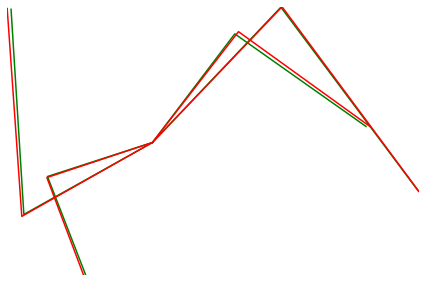

<Figure size 432x288 with 0 Axes>

In [176]:
compare_states(Y[0], Y_hat[0], overlap=True)

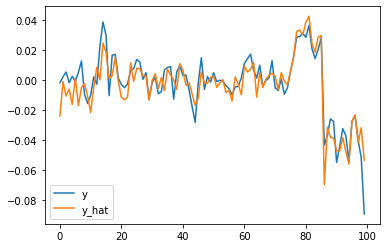

In [177]:
plot_velocity_curve(true=Y[0, :, 0], pred=Y_hat[0, :, 0])

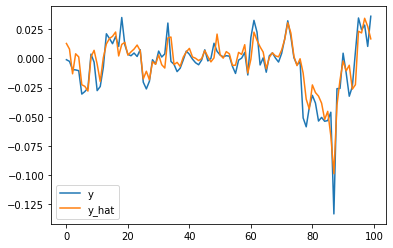

In [178]:
plot_velocity_curve(true=Y[0, :, 1], pred=Y_hat[0, :, 1])

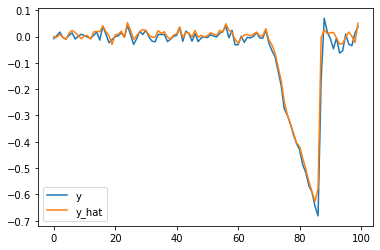

In [179]:
plot_velocity_curve(true=Y[0, :, 2], pred=Y_hat[0, :, 2])

In [164]:
trainer.save_checkpoint(path=root+"/../models/vanilla_rnn.pth")

In [267]:
Y_hat = seq_model.foresee(x=X_test[n:n+1], a=A_test[n:n+1], lookahead=5)
Y = Y_test[n:n+1]

In [268]:
Y_hat.shape

(1, 100, 21)

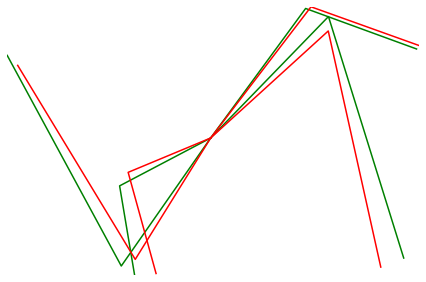

<Figure size 432x288 with 0 Axes>

In [269]:
compare_states(Y[0], Y_hat[0], overlap=True)

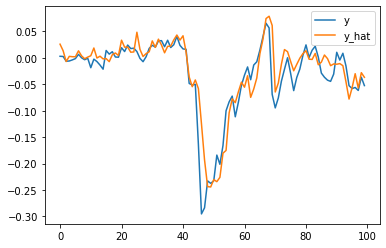

In [256]:
plot_velocity_curve(true=Y[0, :, 0], pred=Y_hat[0, :, 0])

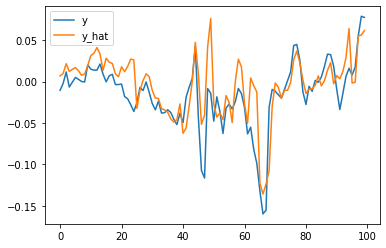

In [257]:
plot_velocity_curve(true=Y[0, :, 1], pred=Y_hat[0, :, 1])

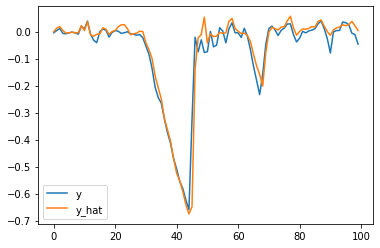

In [258]:
plot_velocity_curve(true=Y[0, :, 2], pred=Y_hat[0, :, 2])